This pipeline processes datasets from __[diffusion weighted images (DWI)](https://en.wikipedia.org/wiki/Diffusion_MRI)__ to __[tractography](https://en.wikipedia.org/wiki/Tractography)__, then extract diffusion metric tract profiles from segmented bundles for statistical analysis. It includes denoising preprocessing, reconstruction, fiber tracking, bundle extraction, streamline analysis and visualiztion.
## Step 0: Input data 
- Diffusion magnetic resonance imaging (dMRI) is an important tool that allows non-invasive investigation of neural architecture of the brain. The data obtained from these in-vivo scans provides important information about the integrity and connectivity of neural fiber bundles in the brain. Usually we use three types of files, a Nifti file with the diffusion weighted data, and two text files one with b-values and one with the b-vectors. 
- The sample data from our scan protocol is multishell dMRI, it acquires 64 and 30 gradient directions for the 2 spherical shells one at b=1000 s/mm2 and one at b=2500 s/mm2, respectively. Also, we include two set of b=0 volumes with phase-encoding A>>P and P>>A. The shape of these two volumes is different for the two different acquisitions. This is what topup will use in order to calculate the susceptibility induced off-resonance field. 

In [1]:
AP_b0 = 'ms4148-mse13358-033-ep2d_se_B0_AP.nii.gz'
PA_b0 = 'ms4148-mse13358-034-ep2d_se_B0_PA.nii.gz'
b700_nii = 'ms4148-mse13358-040-ep2d_diff_Multiband_b700_NODDI-000.nii.gz'
b700_bval = 'ms4148-mse13358-040-ep2d_diff_Multiband_b700_NODDI-001.bval'
b700_bvec = 'ms4148-mse13358-040-ep2d_diff_Multiband_b700_NODDI-002.bvec'
b2000_nii = 'ms4148-mse13358-035-ep2d_diff_Multiband_b2000_NODDI-000.nii.gz'
b2000_bval = 'ms4148-mse13358-035-ep2d_diff_Multiband_b2000_NODDI-001.bval'
b2000_bvec = 'ms4148-mse13358-035-ep2d_diff_Multiband_b2000_NODDI-002.bvec'

Checking what these files look like: <br>
1. Load dMRI datasets (nibabel python library enables us to read and write nuroimaging-specific file formats) 
2. Understand that data is a 4D array where the first 3 dimensions are the i, j, k voxel coordinates and the 
   last dimension is the number of non-weighted (b0) and diffusion-weighted volumes.
3. Use matplotlib to visualize the results 
4. load the b-values and b-vectors using the function read_bvals_bvecs and create object that holds all the 
   acquisition specific parameters using function gradient_table

data shape is: 
 (100, 100, 66, 65)
first 10 b-values are: 
 [   0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]
first 10 b-vectors are: 
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.99681473e-01  2.28615887e-02  1.06971376e-02]
 [ 2.28687227e-02  9.99738216e-01  7.55791611e-04]
 [-1.80669073e-02  6.50007844e-01 -7.59712696e-01]
 [-5.70891976e-01  7.79250562e-01  2.58555621e-01]
 [ 2.54909426e-01  5.18265069e-01  8.16347063e-01]
 [ 9.01505589e-01  2.38814861e-01  3.60908777e-01]
 [ 7.94245541e-01  1.10327616e-01 -5.97496331e-01]
 [ 2.52584517e-01  9.24572468e-01 -2.85248637e-01]
 [ 9.36123073e-01  1.18417889e-01 -3.31135750e-01]]


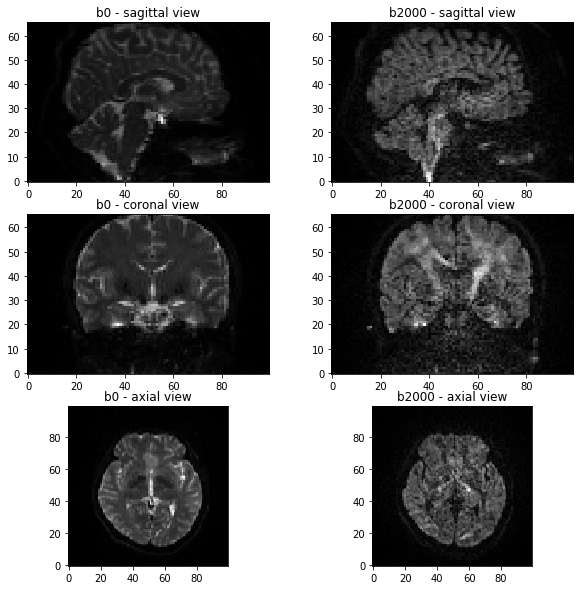

In [2]:
import nibabel as nib
b2000_img = nib.load(b2000_nii)
data = b2000_img.get_data()
print('data shape is: \n {}'.format(data.shape))

%matplotlib inline
import matplotlib.pyplot as plt
fig0, axes = plt.subplots(3, 2, figsize=(10,10))
axes[0,0].imshow(data[data.shape[0]//2, :, :, 0].T, cmap='gray', origin='lower')
axes[0,0].set_title('b0 - sagittal view')
axes[1,0].imshow(data[:, data.shape[1]//2, :, 0].T, cmap='gray', origin='lower')
axes[1,0].set_title('b0 - coronal view')
axes[2,0].imshow(data[:, :, data.shape[2]//2, 0].T, cmap='gray', origin='lower')
axes[2,0].set_title('b0 - axial view')
axes[0,1].imshow(data[data.shape[0]//2, :, :, 10].T, cmap='gray', origin='lower')
axes[0,1].set_title('b2000 - sagittal view')
axes[1,1].imshow(data[:, data.shape[1]//2, :, 10].T, cmap='gray', origin='lower')
axes[1,1].set_title('b2000 - coronal view')
axes[2,1].imshow(data[:, :, data.shape[2]//2, 10].T, cmap='gray', origin='lower')
axes[2,1].set_title('b2000 - axial view')

from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(b2000_bval, b2000_bvec)
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)
print('first 10 b-values are: \n {}'.format(gtab.bvals[:10]))
print('first 10 b-vectors are: \n {}'.format(gtab.bvecs[:10, :]))

## Step 1: Preprocessing
Use __[topup](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/topup)__ (a tool for estimating and correcting susceptibility induced distortions) and __[eddy](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy/UsersGuide#The_eddy_executables)__ (it combines the correction for susceptibility and eddy currents/movements) for preprocessing. After that, we will get a combinced corrected nifti image with rotated bvels. 

In [3]:
import os
import sys
import glob
from subprocess import check_call

def NODDI_eddy():
    # set combined variables
    print('set variables')
    mseID = 'mse13358'
    merged = '{}_combined_images.nii.gz'.format(mseID)
    bval = '{}_combined_images.bval'.format(mseID)
    bvec = '{}_combined_images.bvec'.format(mseID)
    merged_b0 = 'A2P_P2A_b0.nii.gz'
    tp = 'topup_results'
    hf = 'hifi_b0.nii.gz'
    hf_brain = 'hifi_b0_brain.nii.gz'
    hf_brain_mask ='hifi_b0_brain_mask.nii.gz'
    ed = merged[:-7]+'_ec.nii.gz'
    
    # combine files: order 0 700 2000
    print('combining bvec files') 
    file1 = open(b700_bvec, 'r')
    lines1 = [line.strip() for line in file1.readlines()]
    file1.close()
    file2 = open(b2000_bvec, 'r')
    lines2 = [line.strip() for line in file2.readlines()]
    file2.close()
    file3 = open(bvec, 'w')
    to_write = []
    for i,line in enumerate(lines1):
        if i == (len(lines1)-1):
            to_write = '{} {}'.format(line, lines2[i])
            file3.write(to_write)
        else:
            to_write = '{} {}\n'.format(line, lines2[i])
            file3.write(to_write)
    file3.close()
    
    print('combining bval files')
    file1 = open(b700_bval, 'r')
    lines1 = file1.read().strip()
    file1.close()
    file2 = open(b2000_bval, 'r')
    lines2 = file2.read().strip()
    file2.close()
    file3 = open(bval, 'w')
    file3.write(lines1+' '+lines2)
    file3.close()
    
    print('combining nifti files')
    check_call(['fslmerge', '-t', merged, b700_nii, b2000_nii])
    print('combining APPA files')
    check_call(['fslmerge', '-t', merged_b0, AP_b0, PA_b0])
    
    # run topup
    print('performing topup')
    check_call(['topup', 
                  '--imain='+merged_b0, 
                  '--datain='+'/data/henry2/scheng/PROJECT/DIPY/scripts/acqparams.txt',
                  '--config='+'b02b0.cnf',
                  '--out='+tp,
                  '--iout='+hf])
    
    # genarate mask 
    check_call(['fslmaths', hf, '-Tmean', hf])
    check_call(['bet', hf, hf_brain, '-m'])

    # run eddy
    print('performing eddy')
    check_call(['eddy_openmp', 
                  '--imain='+merged,
                  '--mask='+hf_brain_mask,
                  '--acqp='+'/data/henry2/scheng/PROJECT/DIPY/scripts/acqparams.txt',
                  '--index='+'/data/henry2/scheng/PROJECT/DIPY/scripts/index.txt',
                  '--bvecs='+bvec,
                  '--bvals='+bval,
                  '--topup='+tp,
                  '--out='+ed])

    # clean files
    print('delete useless files')
    rotated_bvec = ed[:] + '.eddy_rotated_bvecs'
    new_bvec = merged[:-7] + '_rotated.bvecs'
    check_call(['mv', rotated_bvec, new_bvec])
    files_throw = glob.glob('*eddy*') 
    for i, eddy_file in enumerate(files_throw):
        check_call(['rm', eddy_file]) 
    check_call(['rm', hf, hf_brain, hf_brain_mask])

    return ed, bval, new_bvec

In [4]:
print('Preprocessing coming...')
ed, bval, new_bvec = NODDI_eddy()    

Preprocessing coming...
set variables
combining bvec files
combining bval files
combining nifti files
combining APPA files
performing topup
performing eddy
delete useless files


In [5]:
print('display raw and corrected images')
from IPython.display import Image, display
img1 = Image(url='mse13358_combined_images.gif',  width=200, height=200) 
img2 = Image(url='mse13358_combined_images_ec.gif', width=200, height=200) 
display(img1, img2)

display raw and corrected images


## Step 2: Whole Brain Tracking
Use Constrained Spherical Deconvolution (CSD) for local reconstruction and then generate deterministic streamlines using the fiber directions (peaks) from CSD and fractional anisotropic (FA) from DTI as a stopping criteria for the tracking.

In [6]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.csdeconv import auto_response
from dipy.data import get_sphere
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.direction import peaks_from_model
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import TensorModel
from dipy.tracking.local import LocalTracking, BinaryTissueClassifier
from dipy.tracking import utils
from dipy.tracking.streamline import Streamlines
import numpy as np
from dipy.io.streamline import save_trk


def whole_brain_tracking():
    # load data
    print('loading data')
    data, affine = load_nifti(ed)
    bvals, bvecs = read_bvals_bvecs(bval, new_bvec)
    gtab = gradient_table(bvals, bvecs)
    
    # voxel reconstruction
    print('model fitting and calculating fiber directions in all voxels')
    response, ratio = auto_response(gtab, data)
    sphere = get_sphere('repulsion724')
    csd_model = ConstrainedSphericalDeconvModel(gtab, response)
    b0 = data[:,:,:,gtab.b0s_mask][:,:,:,0]
    b0_img = nib.Nifti1Image(b0, affine)
    nib.save(b0_img, 'b0.nii.gz')
    os.system('bet b0.nii.gz b0_bet.nii.gz -m -R -f 0.15')
    b0_mask = nib.load('b0_bet_mask.nii.gz')
    data_mask = b0_mask.get_data()
    peaks_csd = peaks_from_model(model=csd_model,
                                 data=data,
                                 sphere=sphere,
                                 relative_peak_threshold=.5,
                                 min_separation_angle=25,
                                 mask=data_mask,
                                 return_sh=True,
                                 sh_basis_type='descoteaux07',
                                 sh_order=8,
                                 normalize_peaks=True,
                                 parallel=True,
                                 nbr_processes=4)
    
    # whole brain fiber tracking
    print('fiber tracking by using fiber directions from the csd_model)')
    maskdata, mask = median_otsu(data)
    tenmodel = TensorModel(gtab)
    tenfit = tenmodel.fit(maskdata)
    FA = tenfit.fa
    tracking_mask = np.zeros(FA.shape)
    tracking_mask[FA > 0.1] = 1
    seeding_mask = tracking_mask
    seeds = utils.random_seeds_from_mask(seeding_mask, seeds_count=1, seed_count_per_voxel=True, random_seed=1)
    streamlines_generator = LocalTracking(peaks_csd, BinaryTissueClassifier(tracking_mask), seeds,
                                          affine=np.eye(4), step_size=.5)
    streamlines = Streamlines(streamlines_generator)
    save_trk('whole_brain_tracking.trk', streamlines, affine, shape=data_mask.shape, vox_size=b0_mask.header.get_zooms())
    
whole_brain_tracking()

loading data
model fitting and calculating fiber directions in all voxels
fiber tracking by using fiber directions from the csd_model)


display csd direction filed map and whole brain tracking image 


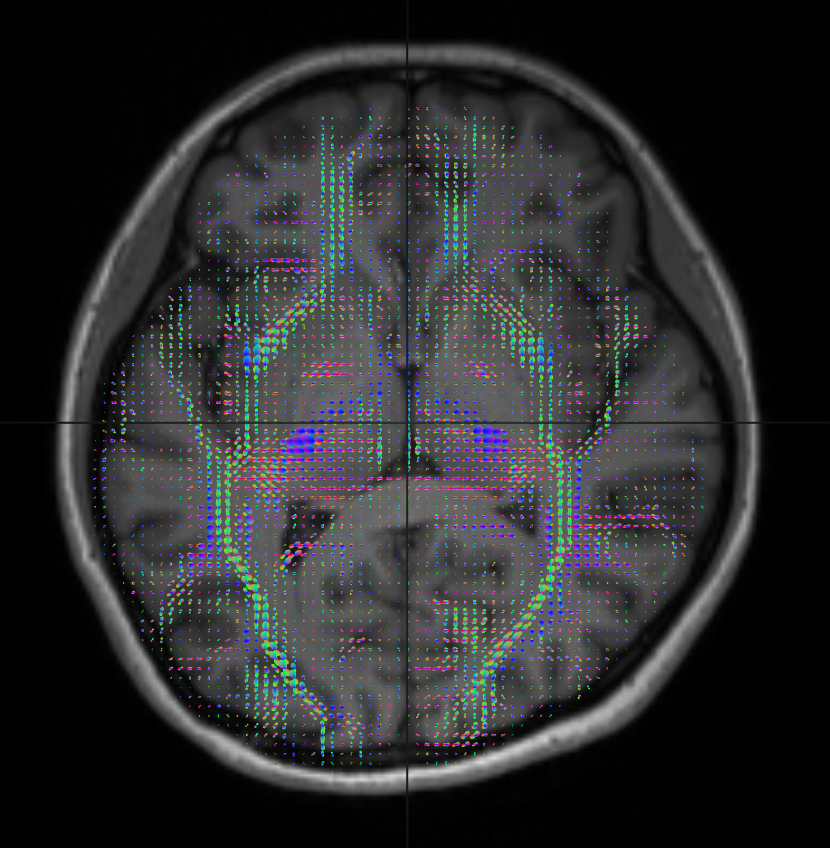

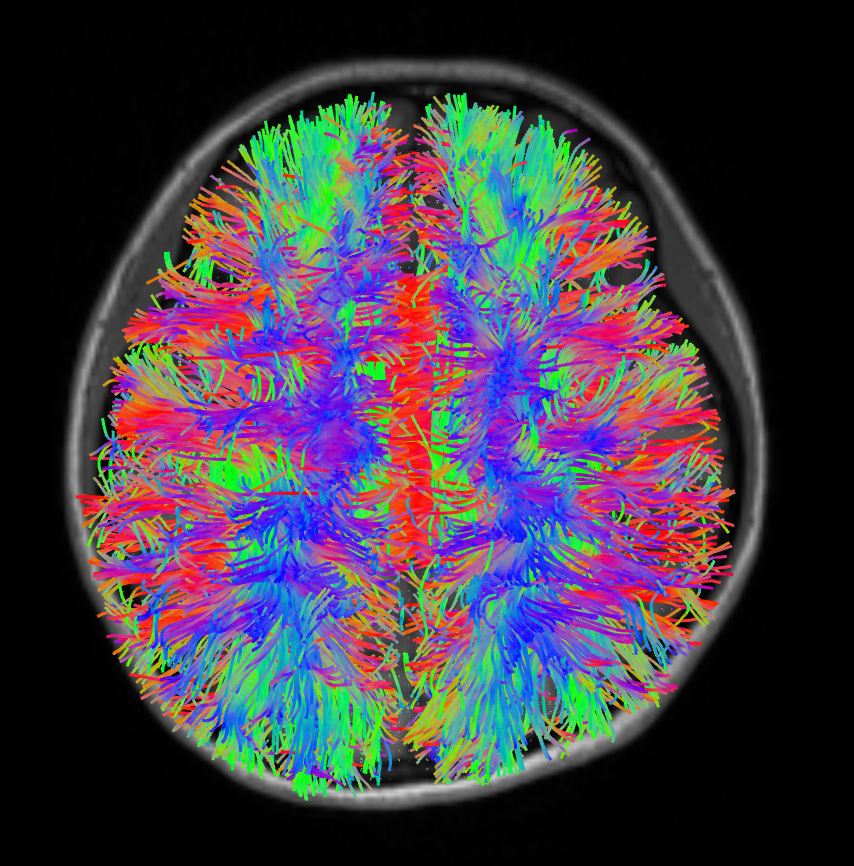

In [7]:
print('display csd direction filed map and whole brain tracking image ')
img3 = Image('csd_direction.png', width=300, height=300)
img4 = Image('whole_brain_track.png', width=300, height=300)
display(img3, img4)

## Step 3: Fiber Bundle Extration
Use RecoBundles __[Garyfallidis17](https://www.ncbi.nlm.nih.gov/pubmed/28712994)__ to extract bundles from tractograms. New command line interfaces:
- dipy_slr  /home/scheng3/.dipy/bundle_atlas_hcp842/Atlas_80_Bundles/whole_brain/whole_brain_MNI.trk whole_brain_tracking.trk 
- dipy_recobundles   moved.trk   /home/scheng3/.dipy/bundle_atlas_hcp842/Atlas_80_Bundles/bundles/CST_L.trk
- dipy_labelsbundles  whole_brain_tracking.trk  labels.npy 

Visualizing extracted Corticospinal Tract (CST) Left bundle


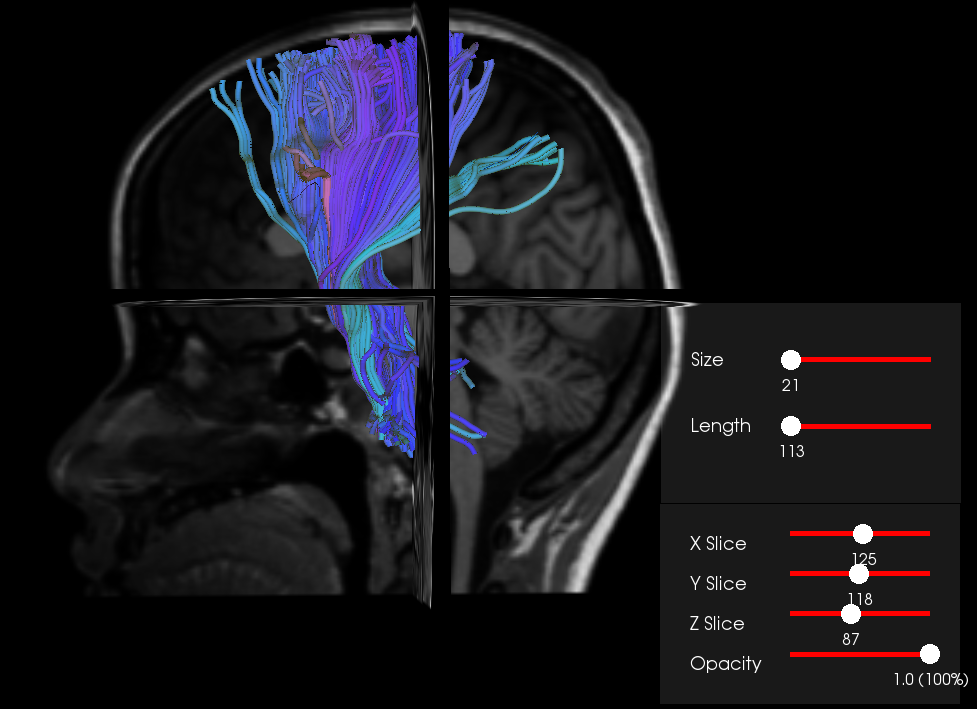

In [8]:
print('Visualizing extracted Corticospinal Tract (CST) Left bundle')
Image('cst_track.png', width=600, height=600)

## Step 4: Microstructural Model 
- Tensor model (DTI) is influential in demonstrating the utility of diffusion MRI in characterizing the micro-structure of white matter tissue and of the biophysical properties of tissue. 
- Kurtosis tensor model (DKI) can be used to charaterize tissue microstructural heterogeneity and to derive concrete biophysical parameters, such as the density of axonal fibres and diffusion tortuosity. 

In [11]:
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
print('Reconstructing of the diffusion signal with the Tensor model')
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)
dti_FA = tenfit.fa
dti_FA_color = tenfit.color_fa
dti_MD = tenfit.md
dti_AD = tenfit.ad
dti_RD = tenfit.rd
save_nifti(ed[:-7] + '_FA.nii.gz', dti_FA, affine)

print('Reconstructing of the diffusion signal with the kurtosis model')
dkimodel = dki.DiffusionKurtosisModel(gtab)
dkifit = dkimodel.fit(maskdata)
MK = dkifit.mk(0, 3)
AK = dkifit.ak(0, 3)
RK = dkifit.rk(0, 3)
save_nifti(ed[:-7] + '_MK.nii.gz', MK, affine)

Reconstructing of the diffusion signal with the Tensor model
Reconstructing of the diffusion signal with the kurtosis model


Display FA, MD, AD and RD obtained from the tensor model(upper panels) and MK, AK, RK from the kurtosis model


Text(0.5,1,'RK')

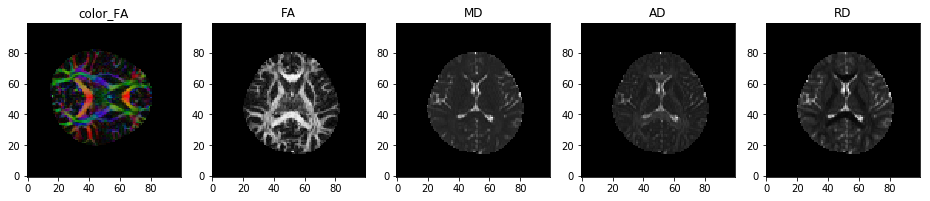

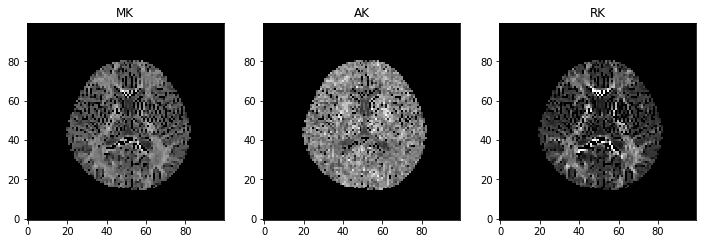

In [12]:
print('Display FA, MD, AD and RD obtained from the tensor model(upper panels) and MK, AK, RK from the kurtosis model')
fig1, axes1 = plt.subplots(1, 5, figsize=(16, 8))
axes1[0].imshow(dti_FA_color[:, :, 39], cmap='gray', origin='lower')
axes1[0].set_title('color_FA')
axes1[1].imshow(dti_FA[:, :, 39].T, cmap='gray', origin='lower')
axes1[1].set_title('FA')
axes1[2].imshow(dti_MD[:, :, 39].T, cmap='gray', origin='lower')
axes1[2].set_title('MD')
axes1[3].imshow(dti_AD[:, :, 39].T, cmap='gray', origin='lower')
axes1[3].set_title('AD')
axes1[4].imshow(dti_RD[:, :, 39].T, cmap='gray', origin='lower')
axes1[4].set_title('RD')


fig2, axes2 = plt.subplots(1, 3, figsize=(12, 6))
axes2[0].imshow(MK[:, :, 39].T, cmap='gray', origin='lower')
axes2[0].set_title('MK')
axes2[1].imshow(AK[:, :, 39].T, cmap='gray', origin='lower')
axes2[1].set_title('AK')
axes2[2].imshow(RK[:, :, 39].T, cmap='gray', origin='lower')
axes2[2].set_title('RK')

## Step 5: Tract Profiles Extraction from Segmented Bundles
Extract the values of a statistic from a volume by weighting the contribution of each streamline to the bundle profile based on how far this streamline is from the mean trajectory of the bundle at that location.

Calculating weights for each bundle and then use the weights to calculate the tract profiles for cst_l bundle
Bundle profiles for the fractional anisotropy and mean kurtosis in left CST


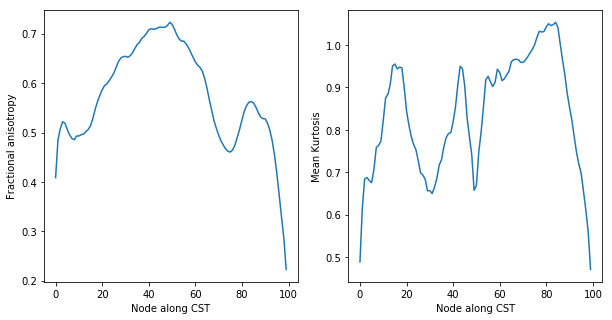

In [13]:
print('Calculating weights for each bundle and then use the weights to calculate the tract profiles for cst_l bundle')
from dipy.io.streamline import load_trk
import dipy.segment.bundles as dsb
cst_l, hdr = load_trk('recognized_orig.trk')
transform = np.load('labels.npy')
w_cst_l = dsb.gaussian_weights(cst_l)
FA_img = nib.load('mse13358_combined_images_ec_FA.nii.gz')
FA_data = FA_img.get_data()
MK_img = nib.load('mse13358_combined_images_ec_MK.nii.gz')
MK_data = MK_img.get_data()
FA_cst_l = dsb.afq_profile(FA_data, cst_l, affine=affine, weights=w_cst_l)
MK_cst_l = dsb.afq_profile(MK_data, cst_l, affine=affine, weights=w_cst_l)

print('Bundle profiles for the fractional anisotropy and mean kurtosis in left CST')
fig3, axes3 = plt.subplots(1, 2, figsize=(10, 5))
axes3[0].plot(FA_cst_l)
axes3[0].set_ylabel('Fractional anisotropy')
axes3[0].set_xlabel('Node along CST')
axes3[1].plot(MK_cst_l)
axes3[1].set_ylabel('Mean Kurtosis')
axes3[1].set_xlabel('Node along CST')

In [14]:
print('FA values along CST bundle are: \n {}'.format(FA_cst_l))

FA values along CST bundle are: 
 [0.40869288 0.48413457 0.50763085 0.5218566  0.5189567  0.50663245
 0.49529482 0.48811212 0.48546636 0.49290811 0.49308204 0.49575877
 0.49678515 0.50181316 0.50628657 0.51400997 0.52862595 0.54737373
 0.56269006 0.57539767 0.58668534 0.59504683 0.59838909 0.60502859
 0.6121008  0.62049847 0.63215812 0.64375247 0.65070344 0.65371436
 0.65429467 0.65246954 0.65549311 0.66126107 0.67007424 0.67799314
 0.68272852 0.69065692 0.69470228 0.70076456 0.70794427 0.71015942
 0.70907633 0.70983031 0.71241302 0.71354569 0.71286612 0.7135032
 0.7165997  0.72313414 0.71918033 0.70975153 0.69826995 0.68954798
 0.68519369 0.68518791 0.67981076 0.67219221 0.66262094 0.65261306
 0.64331226 0.63632861 0.6319     0.62415864 0.60960952 0.58983516
 0.5665269  0.54536163 0.52450472 0.5086519  0.49495219 0.48321373
 0.47447879 0.46702344 0.46185934 0.46055562 0.46462202 0.47474412
 0.49035871 0.50672776 0.52522147 0.54286083 0.55452674 0.56138275
 0.56268444 0.5598881  0.5515